In [61]:
import numpy as np 
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm 
import time

In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a transformação para converter a imagem em tensor
transform = transforms.Compose([transforms.ToTensor()])

# Baixa e carrega o dataset
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [63]:
batchsize = 256
loaderTrain = DataLoader(train_data, shuffle=True, batch_size=batchsize, drop_last=True)
loaderTest = DataLoader(test_data, batch_size=len(test_data))

In [64]:
torch.argmax(train_data[1][0], axis=1)

tensor([[ 0,  0,  0,  0,  0,  0, 19, 19, 14, 12, 11, 10,  9,  9,  7,  6,  9,  4,
          5,  6,  9, 14, 14,  0,  0,  0,  0,  0]])

In [65]:
train_data[0][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [66]:
%whos

Variable         Type          Data/Info
----------------------------------------
AllLosses        list          n=0
AllTest          list          n=0
AllTrain         list          n=0
DataLoader       type          <class 'torch.utils.data.dataloader.DataLoader'>
F                module        <module 'torch.nn.functio<...>/torch/nn/functional.py'>
Optis            list          n=3
Units            list          n=6
X                Tensor        tensor([[[[0., 0., 0.,  .<...>0.,  ..., 0., 0., 0.]]]])
batchsize        int           256
configs          list          n=18
createMNISTNet   function      <function createMNISTNet at 0x761484864040>
datasets         module        <module 'torchvision.data<...>on/datasets/__init__.py'>
device           device        cuda
i                str           Adam
itertools        module        <module 'itertools' (built-in)>
layer            float64       0.0001
layers           list          n=3
loaderTest       DataLoader    <torch.utils.data

In [ ]:
def createMNISTNet(opt, lr):
    class ann(nn.Module):
        def __init__(self):
            super().__init__()
            
            bnIn = nn.BatchNorm1d(784)
            input = nn.Linear(784, 50)
            
            self.layers = nn.ModuleList()
            
            self.layers.append(bnIn)
            self.layers.append(input)
            self.layers.append(nn.ReLU())
            
            for i in range(2):
                block= nn.Sequential(
                    nn.BatchNorm1d(50),
                    nn.Linear(50,50),
                    nn.ReLU()
                )
                self.layers.append(block)
                
            bnOut = nn.BatchNorm1d(50)
            output = nn.Linear(50,10)
            
            self.layers.append(bnOut)
            self.layers.append(output)
        
        def forward(self, x):
            x = x.view(-1,784)
            
            for layer in self.layers:
                x = layer(x)
            
            return torch.log_softmax(x, axis=1)
    
    net = ann()
    lossfun = nn.NLLLoss()
    if opt=="Adam":
        optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    elif opt == "SGD":
        optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    else:
        optimizer = torch.optim.RMSprop(net.parameters(), lr=lr)
    
    return net, lossfun, optimizer

def trainModel(net, lossfun, optimizer):
    trainAcc = []
    testAcc = []
    losses = []
    
    for epoch in tqdm(range(20), desc="Epoch", leave=False):
        batchAcc = []
        batchLoss = []
        net.train()
        
        for X,y in loaderTrain:
            X, y = X, y
            
            y_pred = net(X)
            
            loss = lossfun(y_pred, y)
            batchLoss.append(loss.item())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            acc = 100*torch.mean((torch.argmax(y_pred, axis=1) == y).float()).item()
            batchAcc.append(acc)
    
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))

        net.eval()

        X, y = next(iter(loaderTest))
        y_pred = net(X)

        testAcc.append(100*torch.mean((torch.argmax(y_pred, axis=1) == y).float()).item())
    return np.mean(trainAcc[-10:]), np.mean(testAcc[-10:]), losses
    
        
            

In [68]:
net, lossfun, optimizer = createMNISTNet(3,250)
X,y = next(iter(loaderTrain))

y_pred = net(X)

print(y_pred)
loss = lossfun(y_pred,y)
print("Loss", loss)

tensor([[-2.9325, -2.0598, -2.3695,  ..., -2.2533, -2.4952, -2.2944],
        [-1.8530, -2.6046, -2.5591,  ..., -1.3556, -2.9888, -2.9254],
        [-2.8864, -2.8687, -2.2005,  ..., -1.8150, -2.6785, -2.4030],
        ...,
        [-1.9410, -3.1789, -2.9383,  ..., -1.8615, -2.4808, -2.3716],
        [-2.2745, -2.4868, -1.6380,  ..., -2.3029, -2.7353, -2.6111],
        [-2.6478, -3.6462, -2.1783,  ..., -2.1197, -2.2616, -2.5874]],
       grad_fn=<LogSoftmaxBackward0>)
Loss tensor(2.5020, grad_fn=<NllLossBackward0>)


In [69]:
# train, test, loss = trainModel(net, lossfun, optimizer)

In [70]:
AllTrain, AllTest, AllLosses = [], [], []
Optis = ["Adam", "SGD", "RMSprop"]
lrs = np.logspace(-4,-1,6)
#train, test, loss = trainModel(net, lossfun, optimizer)
import itertools
configs = list(itertools.product(Optis, lrs))

print(f"Iniciando treinamento de {len(configs)} modelos...")

# MODIFICAÇÃO 2: Barra de progresso para os Modelos
for i, lr in tqdm(configs, desc="Modelos Totais"):
    
    # Opcional: print para saber exatamente onde está se der erro
    # tqdm.write usa o print de forma que não quebra a barra de progresso
    tqdm.write(f"Treinando: Otimizator={i}, Learning Rate={lr}") 
    
    net, lossfun, optimizer = createMNISTNet(opt=i, lr=lr)
    # createMNISTNet não joga para GPU automaticamente, então:
    # net.to(device) 
    
    train, test, loss = trainModel(net, lossfun, optimizer)
    
    AllTrain.append(train)
    AllTest.append(test)
    AllLosses.append(loss)

Iniciando treinamento de 18 modelos...


Modelos Totais:   0%|          | 0/18 [00:00<?, ?it/s]

Treinando: Otimizator=Adam, Learning Rate=0.0001


Modelos Totais:   6%|▌         | 1/18 [02:28<41:57, 148.07s/it]

Treinando: Otimizator=Adam, Learning Rate=0.00039810717055349735


Modelos Totais:  11%|█         | 2/18 [04:57<39:38, 148.65s/it]

Treinando: Otimizator=Adam, Learning Rate=0.001584893192461114


Modelos Totais:  17%|█▋        | 3/18 [07:16<36:06, 144.46s/it]

Treinando: Otimizator=Adam, Learning Rate=0.006309573444801929


Modelos Totais:  22%|██▏       | 4/18 [09:34<33:04, 141.78s/it]

Treinando: Otimizator=Adam, Learning Rate=0.025118864315095794


Modelos Totais:  28%|██▊       | 5/18 [11:53<30:31, 140.86s/it]

Treinando: Otimizator=Adam, Learning Rate=0.1


Modelos Totais:  33%|███▎      | 6/18 [14:21<28:37, 143.14s/it]

Treinando: Otimizator=SGD, Learning Rate=0.0001


Modelos Totais:  39%|███▉      | 7/18 [16:33<25:37, 139.75s/it]

Treinando: Otimizator=SGD, Learning Rate=0.00039810717055349735


Modelos Totais:  44%|████▍     | 8/18 [18:50<23:06, 138.62s/it]

Treinando: Otimizator=SGD, Learning Rate=0.001584893192461114


Modelos Totais:  50%|█████     | 9/18 [21:03<20:32, 136.90s/it]

Treinando: Otimizator=SGD, Learning Rate=0.006309573444801929


Modelos Totais:  56%|█████▌    | 10/18 [23:16<18:06, 135.82s/it]

Treinando: Otimizator=SGD, Learning Rate=0.025118864315095794


Modelos Totais:  61%|██████    | 11/18 [25:29<15:45, 135.01s/it]

Treinando: Otimizator=SGD, Learning Rate=0.1


Modelos Totais:  67%|██████▋   | 12/18 [27:43<13:27, 134.65s/it]

Treinando: Otimizator=RMSprop, Learning Rate=0.0001


Modelos Totais:  72%|███████▏  | 13/18 [30:07<11:26, 137.35s/it]

Treinando: Otimizator=RMSprop, Learning Rate=0.00039810717055349735


Modelos Totais:  78%|███████▊  | 14/18 [32:34<09:21, 140.29s/it]

Treinando: Otimizator=RMSprop, Learning Rate=0.001584893192461114


Modelos Totais:  83%|████████▎ | 15/18 [34:59<07:05, 141.87s/it]

Treinando: Otimizator=RMSprop, Learning Rate=0.006309573444801929


Modelos Totais:  89%|████████▉ | 16/18 [37:28<04:47, 143.80s/it]

Treinando: Otimizator=RMSprop, Learning Rate=0.025118864315095794


Modelos Totais:  94%|█████████▍| 17/18 [39:53<02:24, 144.38s/it]

Treinando: Otimizator=RMSprop, Learning Rate=0.1


Modelos Totais: 100%|██████████| 18/18 [42:22<00:00, 141.24s/it]


In [111]:
train = np.array(AllTrain)
test = np.array(AllTest)
loss = np.array(AllLosses)

In [112]:
train.shape

(18, 20)

In [113]:
train

array([[70.1038328 , 89.85877404, 92.24759615, 93.64817041, 94.57465278,
        95.21233974, 95.88842147, 96.33747329, 96.71808226, 97.02023237,
        97.26896368, 97.45759882, 97.75974893, 97.93336004, 98.09528579,
        98.2154781 , 98.4107906 , 98.51262019, 98.60944177, 98.74465812],
       [84.75560897, 94.67648237, 96.22729701, 97.08700588, 97.56109776,
        97.93336004, 98.23050214, 98.47589476, 98.66786859, 98.83647169,
        98.96334135, 99.07852564, 99.13027511, 99.17534722, 99.23544338,
        99.25046741, 99.43409455, 99.480836  , 99.4674813 , 99.45746528],
       [90.44805021, 96.23063568, 97.22889957, 97.74973291, 98.16706731,
        98.46921741, 98.59608707, 98.77136752, 98.87152778, 98.90324519,
        99.14029113, 99.2721688 , 99.22542735, 99.22709669, 99.23878205,
        99.28719284, 99.41907051, 99.46414263, 99.44577991, 99.4674813 ],
       [92.42120726, 96.56784188, 97.37079327, 97.69297543, 98.06857639,
        98.308961  , 98.49258814, 98.66786859, 9

In [114]:
acc_final = np.mean(train[:, -3:], axis=1)


acc_plot = acc_final.reshape(3, 6).T

In [115]:
acc_plot.shape

(6, 3)

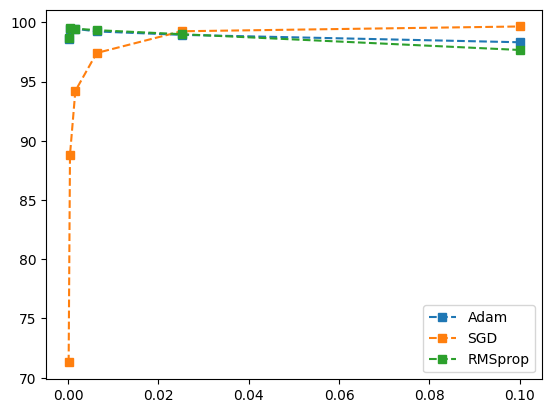

In [118]:
plt.plot(lrs, acc_plot, "s--")
plt.legend(Optis)


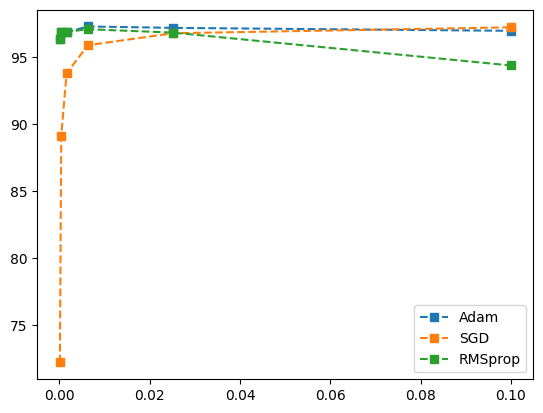

In [119]:
acc_final = np.mean(test[:, -3:], axis=1)


acc_plot_test = acc_final.reshape(3, 6).T
plt.plot(lrs, acc_plot_test, "s--")
plt.legend(Optis)
